# Chap08 - 큐, 스레드, 데이터 읽기

> 텐서플로 파일 형식인 TFRecord를 읽고 쓰는 방법에 대해 알아보자.

## 8.1 입력 파이프라인

MNIST 이미지처럼 용량이 크지 않은 데이터는 메모리에 올려 텐서플로(TensorFlow) 그래프에 데이터를 넣어주는 방법이 편리하지만, 데이터의 용량이 큰 경우에는 메모리에 데이터를 올리는 것이 어려워진다. 이럴 경우에는 데이터를 필요한 만큼 로드하는 방식이 효율적이다.

앞에서 모델링한 딥러닝 모델에 데이터를 넣어주기 위해서 `tf.Session().run()`에서 `feed_dict`인자에 데이터를 넣어 줬었다. 하지만, 이러한 방법은 데이터를 단일 스레드로 복사하여 속도가 느리다는 단점이 있다.

텐서플로에서는 이러한 단점을 보완하는 텐서플로의 표준 파일 형식과 이러한 형식을 인코딩/디코딩할 수 있는 기능 등이 있다. 

## 8.2 TFRecord

텐서플로에서 기본 데이터 형식은 **TFRecord**이며, TFRecord는 이진 파일로 직렬화된 입력 데이터가 담겨있다. 이러한 직렬화는 **프로토콜 버퍼**(Protocol Buffer, protobuf)를 기반으로 하며, 프로토콜 버퍼는 데이터의 구조를 설명하는 스키마를 사용해 데이터를 저장용으로 변환하는 역할을 한다. 텐서플로에서는 원래의 데이터 파일을 사용하는 것보다 TFRecord를 사용하는 것이 더 효율적이다. 

- TFRecord 파일의 모든 데이터는 하나의 메모리 블록에 저장되므로, 파일이 개별로 저장된 입력 파일에 비해 메모리에서 데이터를 읽는 시간이 더 빠르다.
- 텐서플로에서 TFRecord에 최적화된 기능들을 제공하고 있어, 멀티스레드 입력 파이프라인으로 사용하기에 더 적합하다.

### 8.2.1 TFRecordWriter로 쓰기

TFRecord에 대해 알아보았으니, MNIST 데이터를 가지고 TFRecord 형식으로 변환해 보자. 

아래의 코드에서 `from tensorflow.contrib.learn.python.learn.datasets import mnist`의 `read_data_sets()`은  학습(train), 테스트(test), 검증(validation) 데이터가 분리(split)되어있다. 

In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import mnist

# mnist dataset 저장할 디렉터리
save_dir = '../data/mnist'

# save_dir에 MNIST 데이터 받기
data_sets = mnist.read_data_sets(save_dir,
                                 dtype=tf.uint8,
                                 reshape=False,
                                 validation_size=1000)


data_splits = ['train', 'test', 'validation']
for i, split in enumerate(data_splits):
    print("saving %s" % split)
    data_set = data_sets[i]
    
    filename = os.path.join(save_dir, '%s.tfrecords' % split)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(data_set.images.shape[0]):
        image = data_set.images[index].tostring()
        example = tf.train.Example(
            features=tf.train.Features(feature={
                'height': tf.train.Feature(
                            int64_list=tf.train.Int64List(
                                value=[data_set.images.shape[1]])),
                'width': tf.train.Feature(
                            int64_list=tf.train.Int64List(
                                value=[data_set.images.shape[2]])),
                'depth': tf.train.Feature(
                            int64_list=tf.train.Int64List(
                                value=[data_set.images.shape[3]])),
                'label': tf.train.Feature(
                            int64_list=tf.train.Int64List(
                                value=[int(data_set.labels[index])])),
                'image_raw': tf.train.Feature(
                                bytes_list=tf.train.BytesList(
                                    value=[image]))
            }))
    writer.write(example.SerializeToString())
writer.close()

print('train, test, validation TFRecords saved!')

saving train
saving test
saving validation
train, test, validation TFRecords saved!


위의 코드를 하나씩 살펴보도록 하자.

먼저 `tf.python_io.TFRecordWriter()`를 이용해 각 데이터 스플릿에 해당하는 파일명을 지정해 줬ㄷ. 

```python
filename = os.path.join(save_dir, '%s.tfrecords' % split)
writer = tf.python_io.TFRecordWriter(filename)
```

그다음, 각 이미지에 대해 NumPy의 `array`를 byte string으로 변환한다.

```python
image = data_set.images[index].tostring()
```

이렇게 변환된 이미지를 프로토콜 버퍼 형식으로 변환한다. 위의 코드에서 `tf.train.Example`이 데이터를 저장하는 자료구조이다. `Example`객체 안에 `tf.train.Features` 객체를 포함하고 있는데, `Features` 객체는 `tf.trin.Feature`를 포함하고 있으며, `Feature`는 `tf.train.Int64List, BytesList, FloatList`등을 포함할 수 있다. 아래의 코드는 MNIST 이미지의 레이블을 인코딩하는 코드이다.

```python
tf.train.Feature(
    int64_list=tf.train.Int64List(
        value=[int(data_set.labels[index])]))
```

`TFRecordWriter`를 이용해 저장된 데이터가 어떠한 형태인지 `tf.python_io.tf_record_iterator`를 사용해 알아보자. 

In [28]:
filname = os.path.join(save_dir, 'train.tfrecords')
record_iterator = tf.python_io.tf_record_iterator(filename)
serialized_img_example = next(record_iterator)
print(serialized_img_example[:20])  # 일부만 출력

b'\n\xe8\x06\n\x0e\n\x05depth\x12\x05\x1a\x03\n\x01\x01\n'


위의 출력결과에서 확인할 수 있듯이 저장된 데이터의 형태는 바이트 스트링이다. 이러한 바이트 스트링의 형태를 NumPy의 배열로 복구하려면 `ParseFromString()`을 이용하면 된다.

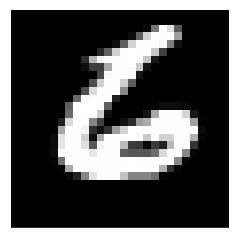

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

example = tf.train.Example()
example.ParseFromString(serialized_img_example)
image = example.features.feature['image_raw'].bytes_list.value
label = example.features.feature['label'].int64_list.value[0]
width = example.features.feature['width'].int64_list.value[0]
height = example.features.feature['height'].int64_list.value[0]
depth = example.features.feature['depth'].int64_list.value[0]

img_flat = np.frombuffer(image[0], dtype=np.uint8)
img_reshape = img_flat.reshape([height, width, depth])
img_plt = img_flat.reshape([height, width])

plt.imshow(img_plt, 'gray')
plt.xticks([]), plt.yticks([]);

## 8.3 큐(Queue)

텐서플로 큐(Queue)는 우리가 알고있는 큐와 같은 역할을 하지만 가장 큰 차이는 텐서플로의 큐는 연산 그래프의 일부분이라는 것이다. 

다음 예제들을 통해 텐서플로의 큐에대해 알아보도록 하자.

### 8.3.1 큐에 넣고 빼기

아래의 예제코드는 최대 10개의 항목을 넣을 수 있는 스트링(string)의 FIFO(First In First Out) 큐를 만들어 본다. 텐서플로의 큐는 연산 그래프의 일부이므로 세션(`tf.Session()`)안에서 수행된다. 

In [1]:
import tensorflow as tf

sess = tf.InteractiveSession()
queue1 = tf.FIFOQueue(capacity=10, dtypes=[tf.string])

위의 코드에서 `queue1`에서 텐서플로 내부적으로 10개의 항목을 저장하기 위한 메모리 버퍼가 생성된다.

#### enqueue()

생성된 `FIFOQueue`에 `enqueue()`를 이용해 항목을 추가해보자.

In [2]:
enque_op = queue1.enqueue(['F'])
print('연산을 실행하기 전 queue1.size() :', sess.run(queue1.size()))

enque_op.run()
print('연산을 실행한 후 queue1.size() :', sess.run(queue1.size()))

연산을 실행하기 전 queue1.size() : 0
연산을 실행한 후 queue1.size() : 1


In [3]:
enque_op = queue1.enqueue(['I'])
enque_op.run()
enque_op = queue1.enqueue(['F'])
enque_op.run()
enque_op = queue1.enqueue(['O'])
enque_op.run()

queue1_size = sess.run(queue1.size())
print('연산을 실행한 후 queue1.size() :', queue1_size)

연산을 실행한 후 queue1.size() : 4


#### dequeue()

이번에는 `dequeue()`를 이용해 `FIFOQueue`에서 항목을 제거해보자. 

In [4]:
x = queue1.dequeue()

for i in range(1, queue1_size+1):
    print('%d 번째 출력 %s' % (i, x.eval()))

1 번째 출력 b'F'
2 번째 출력 b'I'
3 번째 출력 b'F'
4 번째 출력 b'O'


### 8.3.2 멀티스레딩

텐서플로 세션(`tf.Session()`)은 기본적으로 멀티스레드(Multi-Thread)로 실행되며, 여러개의 스레드가 같은 세션을 사용하여 병렬로 연산을 실행한다. 

간단한 샘플 데이터를 이용해 텐서플로의 스레딩 및 스레드와 큐의 상호작용을 살펴보고 난뒤에 MNIST 데이터를 이용해 멀티스레딩을 적용해보도록 하자.

먼저 100개의 항목을 가진 `tf.FIFOQueue`를 생성한다. 

In [1]:
import threading
import time
import tensorflow as tf
from pprint import pprint

sess = tf.InteractiveSession()

# FIFOQueue에 넣을 데이터 생성: -0.81226367과 같이 하나의 값만 출력됨
gen_random_normal = tf.random_normal(shape=()) 
# FIFOQueue 정의
queue = tf.FIFOQueue(capacity=100, dtypes=[tf.float32], shapes=())
enque = queue.enqueue(gen_random_normal)

# sess.run()을 여러번 호출하여
# FIFOQueue에 10개의 아이템을 더하는 함수
def add():
    for i in range(10):
        sess.run(enque)

# 10개의 스레드를 생성
threads = [threading.Thread(target=add, args=()) for i in range(10)]

print('threads:')
pprint(threads)

# FIFOQueue 의 크기가 100이 될때까지 확인
for t in threads:
    t.start()
    
print('='*30)
print('check queue.size():')
print(sess.run(queue.size()))
time.sleep(0.003)
print(sess.run(queue.size()))
time.sleep(0.003)
print(sess.run(queue.size()))

# dequeue_many()를 이용해 10개 아이템 출력
x = queue.dequeue_many(10)
print('='*30)
print('queue.dequeue_many(10):')
print(x.eval())
sess.run(queue.size())

threads:
[<Thread(Thread-6, initial)>,
 <Thread(Thread-7, initial)>,
 <Thread(Thread-8, initial)>,
 <Thread(Thread-9, initial)>,
 <Thread(Thread-10, initial)>,
 <Thread(Thread-11, initial)>,
 <Thread(Thread-12, initial)>,
 <Thread(Thread-13, initial)>,
 <Thread(Thread-14, initial)>,
 <Thread(Thread-15, initial)>]
check queue.size():
17
100
100
queue.dequeue_many(10):
[ 0.88396263  0.14378338 -0.98043966 -1.2009127   0.27303845 -0.8871811
  1.4003232   0.15166609  0.9299293  -1.6246831 ]


90

### 8.3.3 Coordinator와 QueueRunner

위에서 생성한 샘플 데이터가 아닌 실제 데이터에서 멀티스레드를 제대로 동작하게 하는 것은 복잡하다. 예를 들어, 스레드가 중단된 후에는 큐가 닫혀야한다. 

텐서플로는 스레드 셋의 종료를 조정하는 `tf.train.Coordinator`와 데이터를 큐에 넣을 수 있도록 여러개의 스레드를 가져오는 역할을 하는 `tf.train.QueueRunner`를 제공한다.

#### tf.train.Coordinator

`tf.train.Coordinator`의 사용법을 8.3.2에서 처럼 간단한 샘플 데이터를 이용해 알아보자.

어떠한 스레드이건 상관없이 `tf.train.Coordinator`의 `request_stop()`을 통해 모든 스레드를 중단할 수 있다. `tf.train.Coordinator`의 `should_stop()`을 이용해 스레드를 중단할지의 여부를 확인할 수 있다. 

아래의 예제는 `add()`함수에 스레드의 인덱스 `i`를 전달하고 `i==11`일 경우 스레드를 중단하도록 설정하였다. 

In [1]:
import threading
import time
import tensorflow as tf
from pprint import pprint

sess = tf.InteractiveSession()

# FIFOQueue에 넣을 데이터 생성: -0.81226367과 같이 하나의 값만 출력됨
gen_random_normal = tf.random_normal(shape=()) 
# FIFOQueue 정의
queue = tf.FIFOQueue(capacity=100, dtypes=[tf.float32], shapes=())
enque = queue.enqueue(gen_random_normal)

# sess.run()을 여러번 호출하여
# FIFOQueue에 10개의 아이템을 더하는 함수
# i==11 일 경우 스레드를 중지한다.
def add(coord, i):
    while not coord.should_stop():
        sess.run(enque)
        if i == 11:
            coord.request_stop()

# 10개의 스레드를 생성
coord = tf.train.Coordinator()
threads = [threading.Thread(target=add, args=(coord, i)) for i in range(10)]
coord.join(threads)

print('threads:')
pprint(threads)

# FIFOQueue 의 크기가 100이 될때까지 확인
for t in threads:
    t.start()
    
print('='*30)
print('check queue.size():')
print(sess.run(queue.size()))
time.sleep(0.005)
print(sess.run(queue.size()))
time.sleep(0.005)
print(sess.run(queue.size()))

threads:
[<Thread(Thread-6, initial)>,
 <Thread(Thread-7, initial)>,
 <Thread(Thread-8, initial)>,
 <Thread(Thread-9, initial)>,
 <Thread(Thread-10, initial)>,
 <Thread(Thread-11, initial)>,
 <Thread(Thread-12, initial)>,
 <Thread(Thread-13, initial)>,
 <Thread(Thread-14, initial)>,
 <Thread(Thread-15, initial)>]
check queue.size():
29
100
100


#### tf.train.QueueRunner와 tf.RandomShuffleQueue

위의 예제에서는 Python의 `threading`모듈을 이용해 멀티스레드를 구현했지만, 텐서플로에서 제공하는 `tf.train.QueueRunner`를 사용하는 것이 더 낫다. 그 이유는 위의 예제와 동일한 작업을 수행하면서 예외 상황에서는 큐를 닫아준다. 

`tf.RandomShuffleQueue`는 항목을 랜덤하게 꺼내는 큐이며, 데이터의 순서를 섞을 필요가 있는 경사 하강법같은 최적화 함수를 사용해 모델을 학습시킬 때 사용할 수 있다. `tf.RandomShuffleQueue`의 `min_after_dequeue` 인자는 `dequeue` 후에 큐에 남아 있을 아이템의 최소개수를 설정하는 인자이다.

아래의 예제코드는 위의 예제를 `tf.train.QueueRunner`와 `tf.RandomShuffleQueue`를 사용해 구현한 것이다.

In [1]:
import threading
import time
import tensorflow as tf
from pprint import pprint

sess = tf.InteractiveSession()

# RandomShuffleQueue 넣을 데이터 생성: -0.81226367과 같이 하나의 값만 출력됨
gen_random_normal = tf.random_normal(shape=()) 
# RandomShuffleQueue 정의
queue = tf.RandomShuffleQueue(capacity=100, dtypes=[tf.float32],
                              min_after_dequeue=1)
enqueue_op = queue.enqueue(gen_random_normal)

# QueueRunner를 이용한 멀티스레드 구현
qr = tf.train.QueueRunner(queue, [enqueue_op] * 10)
coord = tf.train.Coordinator()
enqueue_threads = qr.create_threads(sess, coord=coord, start=True)
coord.request_stop()
coord.join(enqueue_threads)

print('='*30)
print('check queue.size():')
print(sess.run(queue.size()))
time.sleep(0.005)
print(sess.run(queue.size()))
time.sleep(0.005)
print(sess.run(queue.size()))

print(sess.run(queue.size()))

check queue.size():


AttributeError: 'QueueRunner' object has no attribute 'size'